In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_native_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1079604, 304)
(1079604, 3)
validation
(190293, 304)
(190293, 3)
test
(137379, 304)
(137379, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1001731 (3.82 MB)


Trainable params: 1001731 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:02 - loss: 1.2212 - STD: 0.1505 - MAE: 0.4454

  6/108 [>.............................] - ETA: 1s - loss: 1.1443 - STD: 0.0879 - MAE: 0.4444  

 11/108 [==>...........................] - ETA: 1s - loss: 1.1295 - STD: 0.0721 - MAE: 0.4444

 16/108 [===>..........................] - ETA: 1s - loss: 1.1207 - STD: 0.0588 - MAE: 0.4443

 21/108 [====>.........................] - ETA: 0s - loss: 1.1159 - STD: 0.0512 - MAE: 0.4442

 26/108 [======>.......................] - ETA: 0s - loss: 1.1122 - STD: 0.0459 - MAE: 0.4441

 31/108 [=======>......................] - ETA: 0s - loss: 1.1088 - STD: 0.0408 - MAE: 0.4438

 36/108 [=========>....................] - ETA: 0s - loss: 1.1052 - STD: 0.0378 - MAE: 0.4434

 41/108 [==========>...................] - ETA: 0s - loss: 1.1005 - STD: 0.0369 - MAE: 0.4425

 46/108 [===========>..................] - ETA: 0s - loss: 1.0935 - STD: 0.0392 - MAE: 0.4408

 51/108 [=============>................] - ETA: 0s - loss: 1.0838 - STD: 0.0460 - MAE: 0.4376

 56/108 [==============>...............] - ETA: 0s - loss: 1.0736 - STD: 0.0555 - MAE: 0.4336

 61/108 [===============>..............] - ETA: 0s - loss: 1.0634 - STD: 0.0650 - MAE: 0.4294

 66/108 [=================>............] - ETA: 0s - loss: 1.0530 - STD: 0.0726 - MAE: 0.4256

 71/108 [==================>...........] - ETA: 0s - loss: 1.0429 - STD: 0.0795 - MAE: 0.4219

 76/108 [====================>.........] - ETA: 0s - loss: 1.0335 - STD: 0.0864 - MAE: 0.4183

 81/108 [=====================>........] - ETA: 0s - loss: 1.0245 - STD: 0.0931 - MAE: 0.4146

 86/108 [======================>.......] - ETA: 0s - loss: 1.0160 - STD: 0.0993 - MAE: 0.4112

 91/108 [========================>.....] - ETA: 0s - loss: 1.0082 - STD: 0.1050 - MAE: 0.4081

 96/108 [=========================>....] - ETA: 0s - loss: 1.0002 - STD: 0.1104 - MAE: 0.4049

101/108 [===========================>..] - ETA: 0s - loss: 0.9931 - STD: 0.1158 - MAE: 0.4018

106/108 [============================>.] - ETA: 0s - loss: 0.9865 - STD: 0.1207 - MAE: 0.3990

108/108 [==============================] - 4s 23ms/step - loss: 0.9839 - STD: 0.1225 - MAE: 0.3979 - val_loss: 0.8658 - val_STD: 0.2390 - val_MAE: 0.3362


Epoch 2/10000


  1/108 [..............................] - ETA: 3s - loss: 0.8556 - STD: 0.2295 - MAE: 0.3392

  6/108 [>.............................] - ETA: 1s - loss: 0.8540 - STD: 0.2265 - MAE: 0.3397

 11/108 [==>...........................] - ETA: 1s - loss: 0.8498 - STD: 0.2272 - MAE: 0.3385

 16/108 [===>..........................] - ETA: 0s - loss: 0.8503 - STD: 0.2269 - MAE: 0.3388

 21/108 [====>.........................] - ETA: 0s - loss: 0.8497 - STD: 0.2272 - MAE: 0.3386

 26/108 [======>.......................] - ETA: 0s - loss: 0.8477 - STD: 0.2277 - MAE: 0.3379

 31/108 [=======>......................] - ETA: 0s - loss: 0.8464 - STD: 0.2287 - MAE: 0.3372

 36/108 [=========>....................] - ETA: 0s - loss: 0.8442 - STD: 0.2295 - MAE: 0.3364

 41/108 [==========>...................] - ETA: 0s - loss: 0.8427 - STD: 0.2305 - MAE: 0.3356

 46/108 [===========>..................] - ETA: 0s - loss: 0.8407 - STD: 0.2314 - MAE: 0.3347

 51/108 [=============>................] - ETA: 0s - loss: 0.8387 - STD: 0.2322 - MAE: 0.3339

 56/108 [==============>...............] - ETA: 0s - loss: 0.8370 - STD: 0.2331 - MAE: 0.3331

 61/108 [===============>..............] - ETA: 0s - loss: 0.8352 - STD: 0.2339 - MAE: 0.3323

 66/108 [=================>............] - ETA: 0s - loss: 0.8337 - STD: 0.2347 - MAE: 0.3316

 71/108 [==================>...........] - ETA: 0s - loss: 0.8321 - STD: 0.2357 - MAE: 0.3307

 76/108 [====================>.........] - ETA: 0s - loss: 0.8304 - STD: 0.2365 - MAE: 0.3300

 81/108 [=====================>........] - ETA: 0s - loss: 0.8287 - STD: 0.2374 - MAE: 0.3292

 86/108 [======================>.......] - ETA: 0s - loss: 0.8271 - STD: 0.2382 - MAE: 0.3285

 91/108 [========================>.....] - ETA: 0s - loss: 0.8260 - STD: 0.2390 - MAE: 0.3279

 96/108 [=========================>....] - ETA: 0s - loss: 0.8247 - STD: 0.2396 - MAE: 0.3273

101/108 [===========================>..] - ETA: 0s - loss: 0.8234 - STD: 0.2403 - MAE: 0.3267

106/108 [============================>.] - ETA: 0s - loss: 0.8223 - STD: 0.2409 - MAE: 0.3261

108/108 [==============================] - 1s 12ms/step - loss: 0.8219 - STD: 0.2411 - MAE: 0.3259 - val_loss: 0.8207 - val_STD: 0.2714 - val_MAE: 0.3089


Epoch 3/10000


  1/108 [..............................] - ETA: 4s - loss: 0.8039 - STD: 0.2588 - MAE: 0.3138

  6/108 [>.............................] - ETA: 1s - loss: 0.7988 - STD: 0.2557 - MAE: 0.3139

 11/108 [==>...........................] - ETA: 1s - loss: 0.7960 - STD: 0.2556 - MAE: 0.3133

 16/108 [===>..........................] - ETA: 0s - loss: 0.7942 - STD: 0.2556 - MAE: 0.3129

 21/108 [====>.........................] - ETA: 0s - loss: 0.7945 - STD: 0.2564 - MAE: 0.3126

 26/108 [======>.......................] - ETA: 0s - loss: 0.7947 - STD: 0.2563 - MAE: 0.3126

 31/108 [=======>......................] - ETA: 0s - loss: 0.7944 - STD: 0.2563 - MAE: 0.3126

 36/108 [=========>....................] - ETA: 0s - loss: 0.7933 - STD: 0.2564 - MAE: 0.3124

 41/108 [==========>...................] - ETA: 0s - loss: 0.7919 - STD: 0.2566 - MAE: 0.3120

 46/108 [===========>..................] - ETA: 0s - loss: 0.7907 - STD: 0.2570 - MAE: 0.3115

 51/108 [=============>................] - ETA: 0s - loss: 0.7899 - STD: 0.2572 - MAE: 0.3112

 56/108 [==============>...............] - ETA: 0s - loss: 0.7889 - STD: 0.2577 - MAE: 0.3108

 61/108 [===============>..............] - ETA: 0s - loss: 0.7881 - STD: 0.2581 - MAE: 0.3104

 66/108 [=================>............] - ETA: 0s - loss: 0.7875 - STD: 0.2582 - MAE: 0.3102

 71/108 [==================>...........] - ETA: 0s - loss: 0.7870 - STD: 0.2584 - MAE: 0.3101

 76/108 [====================>.........] - ETA: 0s - loss: 0.7861 - STD: 0.2587 - MAE: 0.3097

 81/108 [=====================>........] - ETA: 0s - loss: 0.7853 - STD: 0.2589 - MAE: 0.3095

 86/108 [======================>.......] - ETA: 0s - loss: 0.7845 - STD: 0.2593 - MAE: 0.3091

 91/108 [========================>.....] - ETA: 0s - loss: 0.7842 - STD: 0.2595 - MAE: 0.3089

 96/108 [=========================>....] - ETA: 0s - loss: 0.7834 - STD: 0.2597 - MAE: 0.3087

101/108 [===========================>..] - ETA: 0s - loss: 0.7826 - STD: 0.2599 - MAE: 0.3084

107/108 [============================>.] - ETA: 0s - loss: 0.7819 - STD: 0.2601 - MAE: 0.3082

108/108 [==============================] - 1s 12ms/step - loss: 0.7816 - STD: 0.2602 - MAE: 0.3081 - val_loss: 0.7689 - val_STD: 0.2811 - val_MAE: 0.2922


Epoch 4/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7613 - STD: 0.2662 - MAE: 0.3004

  6/108 [>.............................] - ETA: 1s - loss: 0.7616 - STD: 0.2674 - MAE: 0.3000

 11/108 [==>...........................] - ETA: 1s - loss: 0.7608 - STD: 0.2673 - MAE: 0.2999

 16/108 [===>..........................] - ETA: 0s - loss: 0.7600 - STD: 0.2678 - MAE: 0.2995

 21/108 [====>.........................] - ETA: 0s - loss: 0.7603 - STD: 0.2680 - MAE: 0.2995

 26/108 [======>.......................] - ETA: 0s - loss: 0.7599 - STD: 0.2682 - MAE: 0.2993

 31/108 [=======>......................] - ETA: 0s - loss: 0.7606 - STD: 0.2687 - MAE: 0.2992

 36/108 [=========>....................] - ETA: 0s - loss: 0.7622 - STD: 0.2690 - MAE: 0.2993

 41/108 [==========>...................] - ETA: 0s - loss: 0.7628 - STD: 0.2693 - MAE: 0.2993

 46/108 [===========>..................] - ETA: 0s - loss: 0.7634 - STD: 0.2696 - MAE: 0.2993

 51/108 [=============>................] - ETA: 0s - loss: 0.7628 - STD: 0.2696 - MAE: 0.2992

 56/108 [==============>...............] - ETA: 0s - loss: 0.7625 - STD: 0.2693 - MAE: 0.2992

 61/108 [===============>..............] - ETA: 0s - loss: 0.7620 - STD: 0.2694 - MAE: 0.2991

 66/108 [=================>............] - ETA: 0s - loss: 0.7612 - STD: 0.2693 - MAE: 0.2990

 71/108 [==================>...........] - ETA: 0s - loss: 0.7602 - STD: 0.2694 - MAE: 0.2987

 76/108 [====================>.........] - ETA: 0s - loss: 0.7596 - STD: 0.2697 - MAE: 0.2984

 81/108 [=====================>........] - ETA: 0s - loss: 0.7587 - STD: 0.2700 - MAE: 0.2981

 86/108 [======================>.......] - ETA: 0s - loss: 0.7579 - STD: 0.2703 - MAE: 0.2978

 91/108 [========================>.....] - ETA: 0s - loss: 0.7575 - STD: 0.2705 - MAE: 0.2976

 96/108 [=========================>....] - ETA: 0s - loss: 0.7572 - STD: 0.2706 - MAE: 0.2975

101/108 [===========================>..] - ETA: 0s - loss: 0.7566 - STD: 0.2706 - MAE: 0.2973

106/108 [============================>.] - ETA: 0s - loss: 0.7560 - STD: 0.2708 - MAE: 0.2971

108/108 [==============================] - 1s 12ms/step - loss: 0.7556 - STD: 0.2709 - MAE: 0.2970 - val_loss: 0.7595 - val_STD: 0.2962 - val_MAE: 0.2814


Epoch 5/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7603 - STD: 0.2796 - MAE: 0.2935

  6/108 [>.............................] - ETA: 1s - loss: 0.7529 - STD: 0.2777 - MAE: 0.2928

 11/108 [==>...........................] - ETA: 0s - loss: 0.7490 - STD: 0.2765 - MAE: 0.2926

 16/108 [===>..........................] - ETA: 0s - loss: 0.7481 - STD: 0.2757 - MAE: 0.2928

 21/108 [====>.........................] - ETA: 0s - loss: 0.7466 - STD: 0.2759 - MAE: 0.2924

 26/108 [======>.......................] - ETA: 0s - loss: 0.7467 - STD: 0.2763 - MAE: 0.2922

 31/108 [=======>......................] - ETA: 0s - loss: 0.7484 - STD: 0.2768 - MAE: 0.2923

 36/108 [=========>....................] - ETA: 0s - loss: 0.7487 - STD: 0.2766 - MAE: 0.2924

 41/108 [==========>...................] - ETA: 0s - loss: 0.7487 - STD: 0.2763 - MAE: 0.2926

 46/108 [===========>..................] - ETA: 0s - loss: 0.7481 - STD: 0.2759 - MAE: 0.2927

 51/108 [=============>................] - ETA: 0s - loss: 0.7475 - STD: 0.2760 - MAE: 0.2925

 56/108 [==============>...............] - ETA: 0s - loss: 0.7464 - STD: 0.2760 - MAE: 0.2922

 61/108 [===============>..............] - ETA: 0s - loss: 0.7464 - STD: 0.2761 - MAE: 0.2921

 66/108 [=================>............] - ETA: 0s - loss: 0.7462 - STD: 0.2761 - MAE: 0.2921

 71/108 [==================>...........] - ETA: 0s - loss: 0.7459 - STD: 0.2761 - MAE: 0.2921

 76/108 [====================>.........] - ETA: 0s - loss: 0.7451 - STD: 0.2762 - MAE: 0.2919

 81/108 [=====================>........] - ETA: 0s - loss: 0.7449 - STD: 0.2763 - MAE: 0.2918

 86/108 [======================>.......] - ETA: 0s - loss: 0.7442 - STD: 0.2764 - MAE: 0.2916

 91/108 [========================>.....] - ETA: 0s - loss: 0.7439 - STD: 0.2766 - MAE: 0.2914

 96/108 [=========================>....] - ETA: 0s - loss: 0.7439 - STD: 0.2766 - MAE: 0.2913

101/108 [===========================>..] - ETA: 0s - loss: 0.7435 - STD: 0.2767 - MAE: 0.2912

106/108 [============================>.] - ETA: 0s - loss: 0.7431 - STD: 0.2768 - MAE: 0.2911

108/108 [==============================] - 1s 12ms/step - loss: 0.7431 - STD: 0.2767 - MAE: 0.2911 - val_loss: 0.7578 - val_STD: 0.2943 - val_MAE: 0.2821


Epoch 6/10000


  1/108 [..............................] - ETA: 4s - loss: 0.7431 - STD: 0.2772 - MAE: 0.2910

  6/108 [>.............................] - ETA: 1s - loss: 0.7395 - STD: 0.2802 - MAE: 0.2885

 11/108 [==>...........................] - ETA: 1s - loss: 0.7390 - STD: 0.2802 - MAE: 0.2884

 16/108 [===>..........................] - ETA: 0s - loss: 0.7421 - STD: 0.2805 - MAE: 0.2888

 21/108 [====>.........................] - ETA: 0s - loss: 0.7424 - STD: 0.2807 - MAE: 0.2887

 26/108 [======>.......................] - ETA: 0s - loss: 0.7427 - STD: 0.2802 - MAE: 0.2891

 31/108 [=======>......................] - ETA: 0s - loss: 0.7414 - STD: 0.2801 - MAE: 0.2889

 36/108 [=========>....................] - ETA: 0s - loss: 0.7404 - STD: 0.2797 - MAE: 0.2888

 41/108 [==========>...................] - ETA: 0s - loss: 0.7399 - STD: 0.2795 - MAE: 0.2888

 46/108 [===========>..................] - ETA: 0s - loss: 0.7393 - STD: 0.2796 - MAE: 0.2886

 51/108 [=============>................] - ETA: 0s - loss: 0.7390 - STD: 0.2795 - MAE: 0.2886

 56/108 [==============>...............] - ETA: 0s - loss: 0.7391 - STD: 0.2793 - MAE: 0.2888

 61/108 [===============>..............] - ETA: 0s - loss: 0.7380 - STD: 0.2793 - MAE: 0.2885

 66/108 [=================>............] - ETA: 0s - loss: 0.7379 - STD: 0.2794 - MAE: 0.2885

 71/108 [==================>...........] - ETA: 0s - loss: 0.7376 - STD: 0.2793 - MAE: 0.2885

 76/108 [====================>.........] - ETA: 0s - loss: 0.7373 - STD: 0.2795 - MAE: 0.2883

 81/108 [=====================>........] - ETA: 0s - loss: 0.7373 - STD: 0.2796 - MAE: 0.2882

 86/108 [======================>.......] - ETA: 0s - loss: 0.7366 - STD: 0.2795 - MAE: 0.2881

 91/108 [========================>.....] - ETA: 0s - loss: 0.7361 - STD: 0.2797 - MAE: 0.2879

 96/108 [=========================>....] - ETA: 0s - loss: 0.7358 - STD: 0.2798 - MAE: 0.2878

101/108 [===========================>..] - ETA: 0s - loss: 0.7351 - STD: 0.2798 - MAE: 0.2876

106/108 [============================>.] - ETA: 0s - loss: 0.7347 - STD: 0.2800 - MAE: 0.2875

108/108 [==============================] - 1s 12ms/step - loss: 0.7345 - STD: 0.2800 - MAE: 0.2874 - val_loss: 0.7442 - val_STD: 0.2984 - val_MAE: 0.2763


Epoch 7/10000


  1/108 [..............................] - ETA: 4s - loss: 0.7320 - STD: 0.2826 - MAE: 0.2855

  6/108 [>.............................] - ETA: 1s - loss: 0.7284 - STD: 0.2820 - MAE: 0.2851

 11/108 [==>...........................] - ETA: 1s - loss: 0.7295 - STD: 0.2827 - MAE: 0.2849

 16/108 [===>..........................] - ETA: 0s - loss: 0.7290 - STD: 0.2819 - MAE: 0.2853

 21/108 [====>.........................] - ETA: 0s - loss: 0.7264 - STD: 0.2823 - MAE: 0.2845

 26/108 [======>.......................] - ETA: 0s - loss: 0.7265 - STD: 0.2825 - MAE: 0.2843

 31/108 [=======>......................] - ETA: 0s - loss: 0.7266 - STD: 0.2827 - MAE: 0.2842

 36/108 [=========>....................] - ETA: 0s - loss: 0.7262 - STD: 0.2831 - MAE: 0.2839

 41/108 [==========>...................] - ETA: 0s - loss: 0.7265 - STD: 0.2829 - MAE: 0.2841

 46/108 [===========>..................] - ETA: 0s - loss: 0.7264 - STD: 0.2830 - MAE: 0.2840

 51/108 [=============>................] - ETA: 0s - loss: 0.7256 - STD: 0.2832 - MAE: 0.2837

 56/108 [==============>...............] - ETA: 0s - loss: 0.7260 - STD: 0.2833 - MAE: 0.2837

 61/108 [===============>..............] - ETA: 0s - loss: 0.7259 - STD: 0.2833 - MAE: 0.2837

 66/108 [=================>............] - ETA: 0s - loss: 0.7268 - STD: 0.2832 - MAE: 0.2840

 71/108 [==================>...........] - ETA: 0s - loss: 0.7268 - STD: 0.2829 - MAE: 0.2841

 76/108 [====================>.........] - ETA: 0s - loss: 0.7265 - STD: 0.2831 - MAE: 0.2840

 81/108 [=====================>........] - ETA: 0s - loss: 0.7265 - STD: 0.2831 - MAE: 0.2840

 86/108 [======================>.......] - ETA: 0s - loss: 0.7264 - STD: 0.2831 - MAE: 0.2839

 91/108 [========================>.....] - ETA: 0s - loss: 0.7261 - STD: 0.2832 - MAE: 0.2838

 96/108 [=========================>....] - ETA: 0s - loss: 0.7262 - STD: 0.2832 - MAE: 0.2838

101/108 [===========================>..] - ETA: 0s - loss: 0.7262 - STD: 0.2833 - MAE: 0.2838

106/108 [============================>.] - ETA: 0s - loss: 0.7262 - STD: 0.2833 - MAE: 0.2837

108/108 [==============================] - 1s 12ms/step - loss: 0.7262 - STD: 0.2834 - MAE: 0.2837 - val_loss: 0.7514 - val_STD: 0.2979 - val_MAE: 0.2784


Epoch 8/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7174 - STD: 0.2818 - MAE: 0.2833

  6/108 [>.............................] - ETA: 1s - loss: 0.7224 - STD: 0.2821 - MAE: 0.2837

 11/108 [==>...........................] - ETA: 1s - loss: 0.7236 - STD: 0.2828 - MAE: 0.2835

 16/108 [===>..........................] - ETA: 0s - loss: 0.7256 - STD: 0.2832 - MAE: 0.2837

 21/108 [====>.........................] - ETA: 0s - loss: 0.7259 - STD: 0.2830 - MAE: 0.2839

 26/108 [======>.......................] - ETA: 0s - loss: 0.7261 - STD: 0.2830 - MAE: 0.2839

 31/108 [=======>......................] - ETA: 0s - loss: 0.7266 - STD: 0.2832 - MAE: 0.2839

 36/108 [=========>....................] - ETA: 0s - loss: 0.7256 - STD: 0.2831 - MAE: 0.2838

 41/108 [==========>...................] - ETA: 0s - loss: 0.7255 - STD: 0.2835 - MAE: 0.2835

 46/108 [===========>..................] - ETA: 0s - loss: 0.7250 - STD: 0.2838 - MAE: 0.2833

 51/108 [=============>................] - ETA: 0s - loss: 0.7246 - STD: 0.2837 - MAE: 0.2832

 56/108 [==============>...............] - ETA: 0s - loss: 0.7243 - STD: 0.2837 - MAE: 0.2832

 61/108 [===============>..............] - ETA: 0s - loss: 0.7236 - STD: 0.2838 - MAE: 0.2829

 66/108 [=================>............] - ETA: 0s - loss: 0.7236 - STD: 0.2839 - MAE: 0.2829

 71/108 [==================>...........] - ETA: 0s - loss: 0.7230 - STD: 0.2840 - MAE: 0.2827

 76/108 [====================>.........] - ETA: 0s - loss: 0.7229 - STD: 0.2841 - MAE: 0.2826

 81/108 [=====================>........] - ETA: 0s - loss: 0.7229 - STD: 0.2841 - MAE: 0.2826

 86/108 [======================>.......] - ETA: 0s - loss: 0.7226 - STD: 0.2842 - MAE: 0.2825

 91/108 [========================>.....] - ETA: 0s - loss: 0.7229 - STD: 0.2843 - MAE: 0.2825

 96/108 [=========================>....] - ETA: 0s - loss: 0.7232 - STD: 0.2845 - MAE: 0.2824

101/108 [===========================>..] - ETA: 0s - loss: 0.7239 - STD: 0.2846 - MAE: 0.2825

106/108 [============================>.] - ETA: 0s - loss: 0.7242 - STD: 0.2846 - MAE: 0.2826

108/108 [==============================] - 1s 12ms/step - loss: 0.7241 - STD: 0.2845 - MAE: 0.2826 - val_loss: 0.7576 - val_STD: 0.2951 - val_MAE: 0.2812


Epoch 9/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7196 - STD: 0.2805 - MAE: 0.2834

  6/108 [>.............................] - ETA: 1s - loss: 0.7197 - STD: 0.2823 - MAE: 0.2828

 11/108 [==>...........................] - ETA: 0s - loss: 0.7204 - STD: 0.2827 - MAE: 0.2827

 16/108 [===>..........................] - ETA: 0s - loss: 0.7204 - STD: 0.2841 - MAE: 0.2820

 21/108 [====>.........................] - ETA: 0s - loss: 0.7211 - STD: 0.2843 - MAE: 0.2820

 26/108 [======>.......................] - ETA: 0s - loss: 0.7211 - STD: 0.2843 - MAE: 0.2821

 31/108 [=======>......................] - ETA: 0s - loss: 0.7208 - STD: 0.2842 - MAE: 0.2821

 36/108 [=========>....................] - ETA: 0s - loss: 0.7204 - STD: 0.2843 - MAE: 0.2820

 41/108 [==========>...................] - ETA: 0s - loss: 0.7203 - STD: 0.2847 - MAE: 0.2817

 46/108 [===========>..................] - ETA: 0s - loss: 0.7200 - STD: 0.2847 - MAE: 0.2817

 51/108 [=============>................] - ETA: 0s - loss: 0.7205 - STD: 0.2850 - MAE: 0.2816

 56/108 [==============>...............] - ETA: 0s - loss: 0.7212 - STD: 0.2852 - MAE: 0.2816

 61/108 [===============>..............] - ETA: 0s - loss: 0.7212 - STD: 0.2854 - MAE: 0.2815

 66/108 [=================>............] - ETA: 0s - loss: 0.7207 - STD: 0.2854 - MAE: 0.2814

 71/108 [==================>...........] - ETA: 0s - loss: 0.7206 - STD: 0.2852 - MAE: 0.2815

 76/108 [====================>.........] - ETA: 0s - loss: 0.7206 - STD: 0.2851 - MAE: 0.2816

 81/108 [=====================>........] - ETA: 0s - loss: 0.7203 - STD: 0.2851 - MAE: 0.2815

 86/108 [======================>.......] - ETA: 0s - loss: 0.7200 - STD: 0.2852 - MAE: 0.2814

 91/108 [========================>.....] - ETA: 0s - loss: 0.7200 - STD: 0.2852 - MAE: 0.2814

 96/108 [=========================>....] - ETA: 0s - loss: 0.7197 - STD: 0.2852 - MAE: 0.2813

101/108 [===========================>..] - ETA: 0s - loss: 0.7194 - STD: 0.2854 - MAE: 0.2811

106/108 [============================>.] - ETA: 0s - loss: 0.7193 - STD: 0.2855 - MAE: 0.2810

108/108 [==============================] - 1s 12ms/step - loss: 0.7192 - STD: 0.2855 - MAE: 0.2810 - val_loss: 0.7568 - val_STD: 0.3023 - val_MAE: 0.2768


Epoch 10/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7051 - STD: 0.2902 - MAE: 0.2750

  6/108 [>.............................] - ETA: 1s - loss: 0.7138 - STD: 0.2873 - MAE: 0.2790

 11/108 [==>...........................] - ETA: 1s - loss: 0.7151 - STD: 0.2861 - MAE: 0.2800

 16/108 [===>..........................] - ETA: 0s - loss: 0.7142 - STD: 0.2862 - MAE: 0.2798

 21/108 [====>.........................] - ETA: 0s - loss: 0.7143 - STD: 0.2863 - MAE: 0.2796

 26/108 [======>.......................] - ETA: 0s - loss: 0.7143 - STD: 0.2867 - MAE: 0.2793

 31/108 [=======>......................] - ETA: 0s - loss: 0.7141 - STD: 0.2871 - MAE: 0.2791

 36/108 [=========>....................] - ETA: 0s - loss: 0.7142 - STD: 0.2872 - MAE: 0.2790

 41/108 [==========>...................] - ETA: 0s - loss: 0.7146 - STD: 0.2873 - MAE: 0.2790

 46/108 [===========>..................] - ETA: 0s - loss: 0.7148 - STD: 0.2872 - MAE: 0.2791

 51/108 [=============>................] - ETA: 0s - loss: 0.7152 - STD: 0.2869 - MAE: 0.2793

 56/108 [==============>...............] - ETA: 0s - loss: 0.7152 - STD: 0.2871 - MAE: 0.2792

 61/108 [===============>..............] - ETA: 0s - loss: 0.7151 - STD: 0.2871 - MAE: 0.2793

 66/108 [=================>............] - ETA: 0s - loss: 0.7152 - STD: 0.2871 - MAE: 0.2793

 71/108 [==================>...........] - ETA: 0s - loss: 0.7153 - STD: 0.2870 - MAE: 0.2793

 76/108 [====================>.........] - ETA: 0s - loss: 0.7151 - STD: 0.2871 - MAE: 0.2792

 81/108 [=====================>........] - ETA: 0s - loss: 0.7156 - STD: 0.2875 - MAE: 0.2791

 86/108 [======================>.......] - ETA: 0s - loss: 0.7160 - STD: 0.2875 - MAE: 0.2792

 91/108 [========================>.....] - ETA: 0s - loss: 0.7157 - STD: 0.2873 - MAE: 0.2792

 96/108 [=========================>....] - ETA: 0s - loss: 0.7153 - STD: 0.2872 - MAE: 0.2792

101/108 [===========================>..] - ETA: 0s - loss: 0.7152 - STD: 0.2874 - MAE: 0.2791

106/108 [============================>.] - ETA: 0s - loss: 0.7147 - STD: 0.2874 - MAE: 0.2790

108/108 [==============================] - 1s 12ms/step - loss: 0.7146 - STD: 0.2873 - MAE: 0.2790 - val_loss: 0.7583 - val_STD: 0.3075 - val_MAE: 0.2738


Epoch 11/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7088 - STD: 0.2930 - MAE: 0.2741

  6/108 [>.............................] - ETA: 1s - loss: 0.7095 - STD: 0.2910 - MAE: 0.2757

 11/108 [==>...........................] - ETA: 1s - loss: 0.7080 - STD: 0.2897 - MAE: 0.2760

 16/108 [===>..........................] - ETA: 0s - loss: 0.7079 - STD: 0.2900 - MAE: 0.2759

 21/108 [====>.........................] - ETA: 0s - loss: 0.7103 - STD: 0.2894 - MAE: 0.2768

 26/108 [======>.......................] - ETA: 0s - loss: 0.7113 - STD: 0.2889 - MAE: 0.2773

 31/108 [=======>......................] - ETA: 0s - loss: 0.7117 - STD: 0.2887 - MAE: 0.2776

 36/108 [=========>....................] - ETA: 0s - loss: 0.7114 - STD: 0.2889 - MAE: 0.2774

 41/108 [==========>...................] - ETA: 0s - loss: 0.7117 - STD: 0.2888 - MAE: 0.2775

 46/108 [===========>..................] - ETA: 0s - loss: 0.7116 - STD: 0.2889 - MAE: 0.2774

 51/108 [=============>................] - ETA: 0s - loss: 0.7114 - STD: 0.2889 - MAE: 0.2774

 56/108 [==============>...............] - ETA: 0s - loss: 0.7114 - STD: 0.2889 - MAE: 0.2774

 61/108 [===============>..............] - ETA: 0s - loss: 0.7112 - STD: 0.2889 - MAE: 0.2773

 66/108 [=================>............] - ETA: 0s - loss: 0.7110 - STD: 0.2889 - MAE: 0.2773

 71/108 [==================>...........] - ETA: 0s - loss: 0.7109 - STD: 0.2889 - MAE: 0.2772

 76/108 [====================>.........] - ETA: 0s - loss: 0.7106 - STD: 0.2890 - MAE: 0.2771

 81/108 [=====================>........] - ETA: 0s - loss: 0.7107 - STD: 0.2890 - MAE: 0.2771

 86/108 [======================>.......] - ETA: 0s - loss: 0.7108 - STD: 0.2890 - MAE: 0.2772

 91/108 [========================>.....] - ETA: 0s - loss: 0.7109 - STD: 0.2889 - MAE: 0.2773

 96/108 [=========================>....] - ETA: 0s - loss: 0.7108 - STD: 0.2889 - MAE: 0.2773

101/108 [===========================>..] - ETA: 0s - loss: 0.7106 - STD: 0.2889 - MAE: 0.2772

106/108 [============================>.] - ETA: 0s - loss: 0.7107 - STD: 0.2890 - MAE: 0.2772

108/108 [==============================] - 1s 12ms/step - loss: 0.7108 - STD: 0.2890 - MAE: 0.2772 - val_loss: 0.7350 - val_STD: 0.3049 - val_MAE: 0.2704


Epoch 12/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7229 - STD: 0.2924 - MAE: 0.2779

  6/108 [>.............................] - ETA: 1s - loss: 0.7129 - STD: 0.2877 - MAE: 0.2783

 11/108 [==>...........................] - ETA: 1s - loss: 0.7123 - STD: 0.2887 - MAE: 0.2776

 16/108 [===>..........................] - ETA: 0s - loss: 0.7105 - STD: 0.2890 - MAE: 0.2769

 21/108 [====>.........................] - ETA: 0s - loss: 0.7120 - STD: 0.2893 - MAE: 0.2772

 26/108 [======>.......................] - ETA: 0s - loss: 0.7123 - STD: 0.2888 - MAE: 0.2776

 31/108 [=======>......................] - ETA: 0s - loss: 0.7119 - STD: 0.2889 - MAE: 0.2775

 36/108 [=========>....................] - ETA: 0s - loss: 0.7116 - STD: 0.2888 - MAE: 0.2775

 41/108 [==========>...................] - ETA: 0s - loss: 0.7110 - STD: 0.2890 - MAE: 0.2772

 46/108 [===========>..................] - ETA: 0s - loss: 0.7107 - STD: 0.2890 - MAE: 0.2772

 51/108 [=============>................] - ETA: 0s - loss: 0.7106 - STD: 0.2887 - MAE: 0.2773

 56/108 [==============>...............] - ETA: 0s - loss: 0.7106 - STD: 0.2890 - MAE: 0.2772

 61/108 [===============>..............] - ETA: 0s - loss: 0.7106 - STD: 0.2890 - MAE: 0.2772

 66/108 [=================>............] - ETA: 0s - loss: 0.7105 - STD: 0.2891 - MAE: 0.2771

 71/108 [==================>...........] - ETA: 0s - loss: 0.7104 - STD: 0.2890 - MAE: 0.2771

 76/108 [====================>.........] - ETA: 0s - loss: 0.7102 - STD: 0.2889 - MAE: 0.2772

 81/108 [=====================>........] - ETA: 0s - loss: 0.7098 - STD: 0.2890 - MAE: 0.2770

 86/108 [======================>.......] - ETA: 0s - loss: 0.7095 - STD: 0.2891 - MAE: 0.2769

 91/108 [========================>.....] - ETA: 0s - loss: 0.7094 - STD: 0.2891 - MAE: 0.2769

 96/108 [=========================>....] - ETA: 0s - loss: 0.7093 - STD: 0.2892 - MAE: 0.2768

101/108 [===========================>..] - ETA: 0s - loss: 0.7095 - STD: 0.2892 - MAE: 0.2768

106/108 [============================>.] - ETA: 0s - loss: 0.7100 - STD: 0.2892 - MAE: 0.2769

108/108 [==============================] - 1s 12ms/step - loss: 0.7102 - STD: 0.2893 - MAE: 0.2769 - val_loss: 0.7879 - val_STD: 0.3086 - val_MAE: 0.2800


Epoch 13/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7191 - STD: 0.2961 - MAE: 0.2753

  6/108 [>.............................] - ETA: 1s - loss: 0.7153 - STD: 0.2902 - MAE: 0.2775

 11/108 [==>...........................] - ETA: 1s - loss: 0.7130 - STD: 0.2884 - MAE: 0.2781

 16/108 [===>..........................] - ETA: 0s - loss: 0.7139 - STD: 0.2877 - MAE: 0.2787

 21/108 [====>.........................] - ETA: 0s - loss: 0.7130 - STD: 0.2872 - MAE: 0.2788

 26/108 [======>.......................] - ETA: 0s - loss: 0.7119 - STD: 0.2875 - MAE: 0.2784

 31/108 [=======>......................] - ETA: 0s - loss: 0.7116 - STD: 0.2876 - MAE: 0.2782

 36/108 [=========>....................] - ETA: 0s - loss: 0.7100 - STD: 0.2881 - MAE: 0.2776

 41/108 [==========>...................] - ETA: 0s - loss: 0.7098 - STD: 0.2883 - MAE: 0.2775

 46/108 [===========>..................] - ETA: 0s - loss: 0.7091 - STD: 0.2884 - MAE: 0.2772

 51/108 [=============>................] - ETA: 0s - loss: 0.7090 - STD: 0.2889 - MAE: 0.2769

 56/108 [==============>...............] - ETA: 0s - loss: 0.7083 - STD: 0.2888 - MAE: 0.2768

 61/108 [===============>..............] - ETA: 0s - loss: 0.7076 - STD: 0.2892 - MAE: 0.2764

 66/108 [=================>............] - ETA: 0s - loss: 0.7075 - STD: 0.2893 - MAE: 0.2763

 71/108 [==================>...........] - ETA: 0s - loss: 0.7075 - STD: 0.2896 - MAE: 0.2762

 76/108 [====================>.........] - ETA: 0s - loss: 0.7073 - STD: 0.2896 - MAE: 0.2762

 81/108 [=====================>........] - ETA: 0s - loss: 0.7069 - STD: 0.2898 - MAE: 0.2760

 86/108 [======================>.......] - ETA: 0s - loss: 0.7065 - STD: 0.2899 - MAE: 0.2758

 91/108 [========================>.....] - ETA: 0s - loss: 0.7068 - STD: 0.2899 - MAE: 0.2759

 96/108 [=========================>....] - ETA: 0s - loss: 0.7068 - STD: 0.2899 - MAE: 0.2759

101/108 [===========================>..] - ETA: 0s - loss: 0.7065 - STD: 0.2899 - MAE: 0.2758

106/108 [============================>.] - ETA: 0s - loss: 0.7065 - STD: 0.2899 - MAE: 0.2758

108/108 [==============================] - 1s 12ms/step - loss: 0.7063 - STD: 0.2899 - MAE: 0.2758 - val_loss: 0.7346 - val_STD: 0.3011 - val_MAE: 0.2728


Epoch 14/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6972 - STD: 0.2914 - MAE: 0.2732

  6/108 [>.............................] - ETA: 1s - loss: 0.7021 - STD: 0.2912 - MAE: 0.2742

 11/108 [==>...........................] - ETA: 0s - loss: 0.7025 - STD: 0.2919 - MAE: 0.2739

 16/108 [===>..........................] - ETA: 0s - loss: 0.7054 - STD: 0.2915 - MAE: 0.2747

 21/108 [====>.........................] - ETA: 0s - loss: 0.7087 - STD: 0.2912 - MAE: 0.2756

 26/108 [======>.......................] - ETA: 0s - loss: 0.7105 - STD: 0.2909 - MAE: 0.2762

 31/108 [=======>......................] - ETA: 0s - loss: 0.7100 - STD: 0.2902 - MAE: 0.2764

 36/108 [=========>....................] - ETA: 0s - loss: 0.7094 - STD: 0.2903 - MAE: 0.2763

 41/108 [==========>...................] - ETA: 0s - loss: 0.7093 - STD: 0.2899 - MAE: 0.2765

 46/108 [===========>..................] - ETA: 0s - loss: 0.7087 - STD: 0.2899 - MAE: 0.2764

 51/108 [=============>................] - ETA: 0s - loss: 0.7073 - STD: 0.2900 - MAE: 0.2760

 56/108 [==============>...............] - ETA: 0s - loss: 0.7067 - STD: 0.2903 - MAE: 0.2757

 61/108 [===============>..............] - ETA: 0s - loss: 0.7065 - STD: 0.2904 - MAE: 0.2756

 66/108 [=================>............] - ETA: 0s - loss: 0.7065 - STD: 0.2905 - MAE: 0.2755

 71/108 [==================>...........] - ETA: 0s - loss: 0.7066 - STD: 0.2906 - MAE: 0.2755

 76/108 [====================>.........] - ETA: 0s - loss: 0.7061 - STD: 0.2906 - MAE: 0.2754

 81/108 [=====================>........] - ETA: 0s - loss: 0.7057 - STD: 0.2908 - MAE: 0.2752

 86/108 [======================>.......] - ETA: 0s - loss: 0.7055 - STD: 0.2906 - MAE: 0.2752

 91/108 [========================>.....] - ETA: 0s - loss: 0.7055 - STD: 0.2908 - MAE: 0.2751

 96/108 [=========================>....] - ETA: 0s - loss: 0.7051 - STD: 0.2908 - MAE: 0.2750

101/108 [===========================>..] - ETA: 0s - loss: 0.7048 - STD: 0.2909 - MAE: 0.2749

106/108 [============================>.] - ETA: 0s - loss: 0.7047 - STD: 0.2908 - MAE: 0.2749

108/108 [==============================] - 1s 12ms/step - loss: 0.7046 - STD: 0.2908 - MAE: 0.2749 - val_loss: 0.7282 - val_STD: 0.2993 - val_MAE: 0.2727


Epoch 15/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6978 - STD: 0.2897 - MAE: 0.2741

  6/108 [>.............................] - ETA: 1s - loss: 0.7013 - STD: 0.2931 - MAE: 0.2729

 11/108 [==>...........................] - ETA: 1s - loss: 0.7019 - STD: 0.2917 - MAE: 0.2739

 16/108 [===>..........................] - ETA: 0s - loss: 0.7010 - STD: 0.2926 - MAE: 0.2732

 21/108 [====>.........................] - ETA: 0s - loss: 0.7016 - STD: 0.2921 - MAE: 0.2736

 26/108 [======>.......................] - ETA: 0s - loss: 0.7029 - STD: 0.2926 - MAE: 0.2735

 31/108 [=======>......................] - ETA: 0s - loss: 0.7034 - STD: 0.2925 - MAE: 0.2736

 36/108 [=========>....................] - ETA: 0s - loss: 0.7029 - STD: 0.2924 - MAE: 0.2736

 41/108 [==========>...................] - ETA: 0s - loss: 0.7019 - STD: 0.2922 - MAE: 0.2735

 46/108 [===========>..................] - ETA: 0s - loss: 0.7021 - STD: 0.2923 - MAE: 0.2735

 51/108 [=============>................] - ETA: 0s - loss: 0.7016 - STD: 0.2920 - MAE: 0.2735

 56/108 [==============>...............] - ETA: 0s - loss: 0.7010 - STD: 0.2919 - MAE: 0.2735

 61/108 [===============>..............] - ETA: 0s - loss: 0.7012 - STD: 0.2919 - MAE: 0.2735

 66/108 [=================>............] - ETA: 0s - loss: 0.7009 - STD: 0.2921 - MAE: 0.2734

 71/108 [==================>...........] - ETA: 0s - loss: 0.7010 - STD: 0.2922 - MAE: 0.2734

 76/108 [====================>.........] - ETA: 0s - loss: 0.7009 - STD: 0.2921 - MAE: 0.2734

 81/108 [=====================>........] - ETA: 0s - loss: 0.7006 - STD: 0.2922 - MAE: 0.2733

 86/108 [======================>.......] - ETA: 0s - loss: 0.7005 - STD: 0.2922 - MAE: 0.2733

 91/108 [========================>.....] - ETA: 0s - loss: 0.7005 - STD: 0.2921 - MAE: 0.2733

 96/108 [=========================>....] - ETA: 0s - loss: 0.7011 - STD: 0.2921 - MAE: 0.2734

101/108 [===========================>..] - ETA: 0s - loss: 0.7014 - STD: 0.2922 - MAE: 0.2735

106/108 [============================>.] - ETA: 0s - loss: 0.7013 - STD: 0.2920 - MAE: 0.2735

108/108 [==============================] - 1s 12ms/step - loss: 0.7013 - STD: 0.2920 - MAE: 0.2735 - val_loss: 0.7438 - val_STD: 0.3003 - val_MAE: 0.2758


Epoch 16/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7045 - STD: 0.2907 - MAE: 0.2753

  6/108 [>.............................] - ETA: 1s - loss: 0.7022 - STD: 0.2920 - MAE: 0.2738

 11/108 [==>...........................] - ETA: 1s - loss: 0.6998 - STD: 0.2923 - MAE: 0.2731

 16/108 [===>..........................] - ETA: 0s - loss: 0.6976 - STD: 0.2918 - MAE: 0.2729

 21/108 [====>.........................] - ETA: 0s - loss: 0.6989 - STD: 0.2922 - MAE: 0.2729

 26/108 [======>.......................] - ETA: 0s - loss: 0.6989 - STD: 0.2920 - MAE: 0.2730

 31/108 [=======>......................] - ETA: 0s - loss: 0.6995 - STD: 0.2918 - MAE: 0.2733

 36/108 [=========>....................] - ETA: 0s - loss: 0.6988 - STD: 0.2921 - MAE: 0.2729

 41/108 [==========>...................] - ETA: 0s - loss: 0.6989 - STD: 0.2923 - MAE: 0.2729

 46/108 [===========>..................] - ETA: 0s - loss: 0.6988 - STD: 0.2924 - MAE: 0.2728

 51/108 [=============>................] - ETA: 0s - loss: 0.6991 - STD: 0.2926 - MAE: 0.2727

 56/108 [==============>...............] - ETA: 0s - loss: 0.6985 - STD: 0.2924 - MAE: 0.2727

 61/108 [===============>..............] - ETA: 0s - loss: 0.6988 - STD: 0.2925 - MAE: 0.2728

 66/108 [=================>............] - ETA: 0s - loss: 0.6985 - STD: 0.2922 - MAE: 0.2728

 71/108 [==================>...........] - ETA: 0s - loss: 0.6986 - STD: 0.2924 - MAE: 0.2728

 76/108 [====================>.........] - ETA: 0s - loss: 0.6987 - STD: 0.2925 - MAE: 0.2728

 81/108 [=====================>........] - ETA: 0s - loss: 0.6987 - STD: 0.2924 - MAE: 0.2728

 86/108 [======================>.......] - ETA: 0s - loss: 0.6986 - STD: 0.2924 - MAE: 0.2727

 91/108 [========================>.....] - ETA: 0s - loss: 0.6988 - STD: 0.2925 - MAE: 0.2727

 96/108 [=========================>....] - ETA: 0s - loss: 0.6989 - STD: 0.2927 - MAE: 0.2726

101/108 [===========================>..] - ETA: 0s - loss: 0.6993 - STD: 0.2927 - MAE: 0.2727

106/108 [============================>.] - ETA: 0s - loss: 0.7000 - STD: 0.2928 - MAE: 0.2728

108/108 [==============================] - 1s 12ms/step - loss: 0.7004 - STD: 0.2929 - MAE: 0.2728 - val_loss: 0.7753 - val_STD: 0.2886 - val_MAE: 0.2892


Epoch 17/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7476 - STD: 0.2824 - MAE: 0.2888

  6/108 [>.............................] - ETA: 1s - loss: 0.7185 - STD: 0.2892 - MAE: 0.2789

 11/108 [==>...........................] - ETA: 0s - loss: 0.7137 - STD: 0.2866 - MAE: 0.2794

 16/108 [===>..........................] - ETA: 0s - loss: 0.7082 - STD: 0.2871 - MAE: 0.2779

 21/108 [====>.........................] - ETA: 0s - loss: 0.7057 - STD: 0.2875 - MAE: 0.2772

 26/108 [======>.......................] - ETA: 0s - loss: 0.7041 - STD: 0.2883 - MAE: 0.2763

 31/108 [=======>......................] - ETA: 0s - loss: 0.7023 - STD: 0.2890 - MAE: 0.2756

 36/108 [=========>....................] - ETA: 0s - loss: 0.7011 - STD: 0.2897 - MAE: 0.2749

 41/108 [==========>...................] - ETA: 0s - loss: 0.7001 - STD: 0.2901 - MAE: 0.2744

 46/108 [===========>..................] - ETA: 0s - loss: 0.6995 - STD: 0.2905 - MAE: 0.2740

 51/108 [=============>................] - ETA: 0s - loss: 0.6992 - STD: 0.2908 - MAE: 0.2738

 56/108 [==============>...............] - ETA: 0s - loss: 0.6989 - STD: 0.2911 - MAE: 0.2736

 61/108 [===============>..............] - ETA: 0s - loss: 0.6982 - STD: 0.2913 - MAE: 0.2733

 66/108 [=================>............] - ETA: 0s - loss: 0.6980 - STD: 0.2916 - MAE: 0.2731

 71/108 [==================>...........] - ETA: 0s - loss: 0.6976 - STD: 0.2917 - MAE: 0.2729

 76/108 [====================>.........] - ETA: 0s - loss: 0.6976 - STD: 0.2917 - MAE: 0.2729

 81/108 [=====================>........] - ETA: 0s - loss: 0.6970 - STD: 0.2920 - MAE: 0.2727

 86/108 [======================>.......] - ETA: 0s - loss: 0.6968 - STD: 0.2920 - MAE: 0.2726

 91/108 [========================>.....] - ETA: 0s - loss: 0.6965 - STD: 0.2922 - MAE: 0.2724

 96/108 [=========================>....] - ETA: 0s - loss: 0.6965 - STD: 0.2923 - MAE: 0.2724

101/108 [===========================>..] - ETA: 0s - loss: 0.6963 - STD: 0.2925 - MAE: 0.2722

106/108 [============================>.] - ETA: 0s - loss: 0.6959 - STD: 0.2926 - MAE: 0.2721

108/108 [==============================] - 1s 12ms/step - loss: 0.6958 - STD: 0.2926 - MAE: 0.2721 - val_loss: 0.7311 - val_STD: 0.3009 - val_MAE: 0.2729


Epoch 18/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6972 - STD: 0.2938 - MAE: 0.2717

  6/108 [>.............................] - ETA: 1s - loss: 0.6884 - STD: 0.2934 - MAE: 0.2701

 11/108 [==>...........................] - ETA: 1s - loss: 0.6929 - STD: 0.2954 - MAE: 0.2698

 16/108 [===>..........................] - ETA: 0s - loss: 0.6969 - STD: 0.2952 - MAE: 0.2708

 21/108 [====>.........................] - ETA: 0s - loss: 0.7013 - STD: 0.2950 - MAE: 0.2719

 26/108 [======>.......................] - ETA: 0s - loss: 0.7048 - STD: 0.2960 - MAE: 0.2720

 31/108 [=======>......................] - ETA: 0s - loss: 0.7051 - STD: 0.2948 - MAE: 0.2728

 36/108 [=========>....................] - ETA: 0s - loss: 0.7052 - STD: 0.2943 - MAE: 0.2731

 41/108 [==========>...................] - ETA: 0s - loss: 0.7040 - STD: 0.2936 - MAE: 0.2733

 46/108 [===========>..................] - ETA: 0s - loss: 0.7031 - STD: 0.2930 - MAE: 0.2735

 51/108 [=============>................] - ETA: 0s - loss: 0.7022 - STD: 0.2929 - MAE: 0.2733

 56/108 [==============>...............] - ETA: 0s - loss: 0.7019 - STD: 0.2926 - MAE: 0.2734

 61/108 [===============>..............] - ETA: 0s - loss: 0.7020 - STD: 0.2926 - MAE: 0.2734

 66/108 [=================>............] - ETA: 0s - loss: 0.7015 - STD: 0.2924 - MAE: 0.2734

 71/108 [==================>...........] - ETA: 0s - loss: 0.7011 - STD: 0.2925 - MAE: 0.2733

 76/108 [====================>.........] - ETA: 0s - loss: 0.7002 - STD: 0.2924 - MAE: 0.2732

 81/108 [=====================>........] - ETA: 0s - loss: 0.6996 - STD: 0.2925 - MAE: 0.2730

 86/108 [======================>.......] - ETA: 0s - loss: 0.6995 - STD: 0.2926 - MAE: 0.2729

 91/108 [========================>.....] - ETA: 0s - loss: 0.6992 - STD: 0.2928 - MAE: 0.2727

 96/108 [=========================>....] - ETA: 0s - loss: 0.6985 - STD: 0.2929 - MAE: 0.2725

101/108 [===========================>..] - ETA: 0s - loss: 0.6982 - STD: 0.2929 - MAE: 0.2724

106/108 [============================>.] - ETA: 0s - loss: 0.6980 - STD: 0.2930 - MAE: 0.2723

108/108 [==============================] - 1s 12ms/step - loss: 0.6981 - STD: 0.2931 - MAE: 0.2723 - val_loss: 0.7401 - val_STD: 0.2963 - val_MAE: 0.2777


Epoch 19/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6972 - STD: 0.2923 - MAE: 0.2729

  6/108 [>.............................] - ETA: 1s - loss: 0.7000 - STD: 0.2932 - MAE: 0.2727

 11/108 [==>...........................] - ETA: 1s - loss: 0.6965 - STD: 0.2929 - MAE: 0.2723

 16/108 [===>..........................] - ETA: 0s - loss: 0.6931 - STD: 0.2937 - MAE: 0.2710

 21/108 [====>.........................] - ETA: 0s - loss: 0.6921 - STD: 0.2929 - MAE: 0.2713

 26/108 [======>.......................] - ETA: 0s - loss: 0.6914 - STD: 0.2939 - MAE: 0.2706

 31/108 [=======>......................] - ETA: 0s - loss: 0.6906 - STD: 0.2943 - MAE: 0.2702

 36/108 [=========>....................] - ETA: 0s - loss: 0.6905 - STD: 0.2943 - MAE: 0.2701

 41/108 [==========>...................] - ETA: 0s - loss: 0.6908 - STD: 0.2945 - MAE: 0.2701

 46/108 [===========>..................] - ETA: 0s - loss: 0.6903 - STD: 0.2945 - MAE: 0.2700

 51/108 [=============>................] - ETA: 0s - loss: 0.6904 - STD: 0.2947 - MAE: 0.2698

 56/108 [==============>...............] - ETA: 0s - loss: 0.6902 - STD: 0.2947 - MAE: 0.2698

 61/108 [===============>..............] - ETA: 0s - loss: 0.6899 - STD: 0.2946 - MAE: 0.2698

 66/108 [=================>............] - ETA: 0s - loss: 0.6896 - STD: 0.2949 - MAE: 0.2695

 71/108 [==================>...........] - ETA: 0s - loss: 0.6895 - STD: 0.2948 - MAE: 0.2696

 76/108 [====================>.........] - ETA: 0s - loss: 0.6894 - STD: 0.2949 - MAE: 0.2695

 81/108 [=====================>........] - ETA: 0s - loss: 0.6892 - STD: 0.2949 - MAE: 0.2694

 86/108 [======================>.......] - ETA: 0s - loss: 0.6893 - STD: 0.2949 - MAE: 0.2694

 91/108 [========================>.....] - ETA: 0s - loss: 0.6892 - STD: 0.2949 - MAE: 0.2694

 96/108 [=========================>....] - ETA: 0s - loss: 0.6892 - STD: 0.2949 - MAE: 0.2694

101/108 [===========================>..] - ETA: 0s - loss: 0.6894 - STD: 0.2950 - MAE: 0.2694

106/108 [============================>.] - ETA: 0s - loss: 0.6899 - STD: 0.2951 - MAE: 0.2694

108/108 [==============================] - 1s 12ms/step - loss: 0.6903 - STD: 0.2952 - MAE: 0.2695 - val_loss: 0.7193 - val_STD: 0.2953 - val_MAE: 0.2739


Epoch 20/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6893 - STD: 0.2910 - MAE: 0.2720

  6/108 [>.............................] - ETA: 1s - loss: 0.7045 - STD: 0.2972 - MAE: 0.2712

 11/108 [==>...........................] - ETA: 1s - loss: 0.7070 - STD: 0.2955 - MAE: 0.2727

 16/108 [===>..........................] - ETA: 0s - loss: 0.7023 - STD: 0.2942 - MAE: 0.2725

 21/108 [====>.........................] - ETA: 0s - loss: 0.7007 - STD: 0.2932 - MAE: 0.2729

 26/108 [======>.......................] - ETA: 0s - loss: 0.6994 - STD: 0.2926 - MAE: 0.2730

 31/108 [=======>......................] - ETA: 0s - loss: 0.6991 - STD: 0.2923 - MAE: 0.2731

 36/108 [=========>....................] - ETA: 0s - loss: 0.6982 - STD: 0.2925 - MAE: 0.2728

 41/108 [==========>...................] - ETA: 0s - loss: 0.6972 - STD: 0.2925 - MAE: 0.2726

 46/108 [===========>..................] - ETA: 0s - loss: 0.6960 - STD: 0.2926 - MAE: 0.2722

 51/108 [=============>................] - ETA: 0s - loss: 0.6953 - STD: 0.2926 - MAE: 0.2721

 56/108 [==============>...............] - ETA: 0s - loss: 0.6937 - STD: 0.2933 - MAE: 0.2714

 61/108 [===============>..............] - ETA: 0s - loss: 0.6928 - STD: 0.2934 - MAE: 0.2711

 66/108 [=================>............] - ETA: 0s - loss: 0.6921 - STD: 0.2936 - MAE: 0.2708

 71/108 [==================>...........] - ETA: 0s - loss: 0.6917 - STD: 0.2941 - MAE: 0.2704

 76/108 [====================>.........] - ETA: 0s - loss: 0.6920 - STD: 0.2941 - MAE: 0.2705

 81/108 [=====================>........] - ETA: 0s - loss: 0.6920 - STD: 0.2943 - MAE: 0.2704

 86/108 [======================>.......] - ETA: 0s - loss: 0.6920 - STD: 0.2944 - MAE: 0.2703

 91/108 [========================>.....] - ETA: 0s - loss: 0.6915 - STD: 0.2944 - MAE: 0.2702

 96/108 [=========================>....] - ETA: 0s - loss: 0.6915 - STD: 0.2945 - MAE: 0.2702

101/108 [===========================>..] - ETA: 0s - loss: 0.6911 - STD: 0.2945 - MAE: 0.2701

106/108 [============================>.] - ETA: 0s - loss: 0.6908 - STD: 0.2945 - MAE: 0.2700

108/108 [==============================] - 1s 12ms/step - loss: 0.6907 - STD: 0.2946 - MAE: 0.2699 - val_loss: 0.7183 - val_STD: 0.2936 - val_MAE: 0.2748


Epoch 21/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6823 - STD: 0.2896 - MAE: 0.2709

  6/108 [>.............................] - ETA: 1s - loss: 0.6802 - STD: 0.2960 - MAE: 0.2670

 11/108 [==>...........................] - ETA: 1s - loss: 0.6831 - STD: 0.2957 - MAE: 0.2675

 16/108 [===>..........................] - ETA: 0s - loss: 0.6827 - STD: 0.2957 - MAE: 0.2674

 21/108 [====>.........................] - ETA: 0s - loss: 0.6820 - STD: 0.2962 - MAE: 0.2671

 26/108 [======>.......................] - ETA: 0s - loss: 0.6834 - STD: 0.2959 - MAE: 0.2676

 31/108 [=======>......................] - ETA: 0s - loss: 0.6834 - STD: 0.2958 - MAE: 0.2677

 36/108 [=========>....................] - ETA: 0s - loss: 0.6840 - STD: 0.2959 - MAE: 0.2677

 41/108 [==========>...................] - ETA: 0s - loss: 0.6838 - STD: 0.2962 - MAE: 0.2675

 46/108 [===========>..................] - ETA: 0s - loss: 0.6838 - STD: 0.2961 - MAE: 0.2676

 51/108 [=============>................] - ETA: 0s - loss: 0.6830 - STD: 0.2962 - MAE: 0.2673

 56/108 [==============>...............] - ETA: 0s - loss: 0.6821 - STD: 0.2964 - MAE: 0.2670

 61/108 [===============>..............] - ETA: 0s - loss: 0.6821 - STD: 0.2964 - MAE: 0.2670

 66/108 [=================>............] - ETA: 0s - loss: 0.6823 - STD: 0.2964 - MAE: 0.2670

 71/108 [==================>...........] - ETA: 0s - loss: 0.6820 - STD: 0.2966 - MAE: 0.2669

 76/108 [====================>.........] - ETA: 0s - loss: 0.6816 - STD: 0.2967 - MAE: 0.2668

 81/108 [=====================>........] - ETA: 0s - loss: 0.6813 - STD: 0.2968 - MAE: 0.2666

 86/108 [======================>.......] - ETA: 0s - loss: 0.6814 - STD: 0.2969 - MAE: 0.2666

 91/108 [========================>.....] - ETA: 0s - loss: 0.6813 - STD: 0.2971 - MAE: 0.2664

 96/108 [=========================>....] - ETA: 0s - loss: 0.6815 - STD: 0.2971 - MAE: 0.2664

101/108 [===========================>..] - ETA: 0s - loss: 0.6813 - STD: 0.2971 - MAE: 0.2664

106/108 [============================>.] - ETA: 0s - loss: 0.6812 - STD: 0.2970 - MAE: 0.2665

108/108 [==============================] - 1s 12ms/step - loss: 0.6812 - STD: 0.2970 - MAE: 0.2664 - val_loss: 0.7040 - val_STD: 0.2938 - val_MAE: 0.2709


Epoch 22/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6771 - STD: 0.2927 - MAE: 0.2678

  6/108 [>.............................] - ETA: 1s - loss: 0.6793 - STD: 0.2975 - MAE: 0.2658

 11/108 [==>...........................] - ETA: 1s - loss: 0.6773 - STD: 0.2978 - MAE: 0.2652

 16/108 [===>..........................] - ETA: 0s - loss: 0.6766 - STD: 0.2974 - MAE: 0.2652

 21/108 [====>.........................] - ETA: 0s - loss: 0.6759 - STD: 0.2976 - MAE: 0.2649

 26/108 [======>.......................] - ETA: 0s - loss: 0.6751 - STD: 0.2986 - MAE: 0.2642

 31/108 [=======>......................] - ETA: 0s - loss: 0.6760 - STD: 0.2985 - MAE: 0.2644

 36/108 [=========>....................] - ETA: 0s - loss: 0.6772 - STD: 0.2989 - MAE: 0.2645

 41/108 [==========>...................] - ETA: 0s - loss: 0.6780 - STD: 0.2987 - MAE: 0.2648

 46/108 [===========>..................] - ETA: 0s - loss: 0.6784 - STD: 0.2986 - MAE: 0.2649

 51/108 [=============>................] - ETA: 0s - loss: 0.6781 - STD: 0.2986 - MAE: 0.2649

 56/108 [==============>...............] - ETA: 0s - loss: 0.6786 - STD: 0.2985 - MAE: 0.2651

 61/108 [===============>..............] - ETA: 0s - loss: 0.6789 - STD: 0.2982 - MAE: 0.2653

 66/108 [=================>............] - ETA: 0s - loss: 0.6790 - STD: 0.2982 - MAE: 0.2653

 71/108 [==================>...........] - ETA: 0s - loss: 0.6789 - STD: 0.2982 - MAE: 0.2653

 76/108 [====================>.........] - ETA: 0s - loss: 0.6789 - STD: 0.2981 - MAE: 0.2654

 81/108 [=====================>........] - ETA: 0s - loss: 0.6790 - STD: 0.2980 - MAE: 0.2654

 86/108 [======================>.......] - ETA: 0s - loss: 0.6788 - STD: 0.2980 - MAE: 0.2654

 91/108 [========================>.....] - ETA: 0s - loss: 0.6785 - STD: 0.2981 - MAE: 0.2653

 96/108 [=========================>....] - ETA: 0s - loss: 0.6787 - STD: 0.2980 - MAE: 0.2654

101/108 [===========================>..] - ETA: 0s - loss: 0.6786 - STD: 0.2982 - MAE: 0.2653

106/108 [============================>.] - ETA: 0s - loss: 0.6787 - STD: 0.2980 - MAE: 0.2654

108/108 [==============================] - 1s 12ms/step - loss: 0.6786 - STD: 0.2981 - MAE: 0.2653 - val_loss: 0.7293 - val_STD: 0.2926 - val_MAE: 0.2792


Epoch 23/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6796 - STD: 0.2899 - MAE: 0.2712

  6/108 [>.............................] - ETA: 1s - loss: 0.6713 - STD: 0.2990 - MAE: 0.2635

 11/108 [==>...........................] - ETA: 0s - loss: 0.6733 - STD: 0.2981 - MAE: 0.2644

 16/108 [===>..........................] - ETA: 0s - loss: 0.6722 - STD: 0.2988 - MAE: 0.2637

 21/108 [====>.........................] - ETA: 0s - loss: 0.6734 - STD: 0.2994 - MAE: 0.2636

 26/108 [======>.......................] - ETA: 0s - loss: 0.6726 - STD: 0.2995 - MAE: 0.2633

 31/108 [=======>......................] - ETA: 0s - loss: 0.6721 - STD: 0.2995 - MAE: 0.2632

 36/108 [=========>....................] - ETA: 0s - loss: 0.6725 - STD: 0.2994 - MAE: 0.2633

 41/108 [==========>...................] - ETA: 0s - loss: 0.6729 - STD: 0.2995 - MAE: 0.2634

 46/108 [===========>..................] - ETA: 0s - loss: 0.6732 - STD: 0.2992 - MAE: 0.2636

 51/108 [=============>................] - ETA: 0s - loss: 0.6738 - STD: 0.2992 - MAE: 0.2637

 56/108 [==============>...............] - ETA: 0s - loss: 0.6742 - STD: 0.2993 - MAE: 0.2637

 61/108 [===============>..............] - ETA: 0s - loss: 0.6735 - STD: 0.2993 - MAE: 0.2636

 66/108 [=================>............] - ETA: 0s - loss: 0.6738 - STD: 0.2994 - MAE: 0.2636

 71/108 [==================>...........] - ETA: 0s - loss: 0.6743 - STD: 0.2992 - MAE: 0.2639

 76/108 [====================>.........] - ETA: 0s - loss: 0.6742 - STD: 0.2993 - MAE: 0.2638

 81/108 [=====================>........] - ETA: 0s - loss: 0.6742 - STD: 0.2993 - MAE: 0.2638

 86/108 [======================>.......] - ETA: 0s - loss: 0.6740 - STD: 0.2995 - MAE: 0.2636

 91/108 [========================>.....] - ETA: 0s - loss: 0.6739 - STD: 0.2994 - MAE: 0.2637

 96/108 [=========================>....] - ETA: 0s - loss: 0.6737 - STD: 0.2994 - MAE: 0.2636

101/108 [===========================>..] - ETA: 0s - loss: 0.6733 - STD: 0.2994 - MAE: 0.2636

106/108 [============================>.] - ETA: 0s - loss: 0.6731 - STD: 0.2994 - MAE: 0.2635

108/108 [==============================] - 1s 12ms/step - loss: 0.6730 - STD: 0.2994 - MAE: 0.2635 - val_loss: 0.6998 - val_STD: 0.3016 - val_MAE: 0.2657


Epoch 24/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6692 - STD: 0.3017 - MAE: 0.2611

  6/108 [>.............................] - ETA: 1s - loss: 0.6706 - STD: 0.3025 - MAE: 0.2612

 11/108 [==>...........................] - ETA: 0s - loss: 0.6703 - STD: 0.3027 - MAE: 0.2609

 16/108 [===>..........................] - ETA: 0s - loss: 0.6700 - STD: 0.3023 - MAE: 0.2612

 21/108 [====>.........................] - ETA: 0s - loss: 0.6686 - STD: 0.3014 - MAE: 0.2615

 26/108 [======>.......................] - ETA: 0s - loss: 0.6673 - STD: 0.3014 - MAE: 0.2612

 32/108 [=======>......................] - ETA: 0s - loss: 0.6672 - STD: 0.3015 - MAE: 0.2611

 37/108 [=========>....................] - ETA: 0s - loss: 0.6691 - STD: 0.3014 - MAE: 0.2616

 42/108 [==========>...................] - ETA: 0s - loss: 0.6690 - STD: 0.3014 - MAE: 0.2616

 47/108 [============>.................] - ETA: 0s - loss: 0.6688 - STD: 0.3011 - MAE: 0.2617

 52/108 [=============>................] - ETA: 0s - loss: 0.6689 - STD: 0.3011 - MAE: 0.2617

 57/108 [==============>...............] - ETA: 0s - loss: 0.6688 - STD: 0.3013 - MAE: 0.2616

 62/108 [================>.............] - ETA: 0s - loss: 0.6690 - STD: 0.3011 - MAE: 0.2617

 67/108 [=================>............] - ETA: 0s - loss: 0.6692 - STD: 0.3011 - MAE: 0.2618

 72/108 [===================>..........] - ETA: 0s - loss: 0.6693 - STD: 0.3009 - MAE: 0.2619

 77/108 [====================>.........] - ETA: 0s - loss: 0.6691 - STD: 0.3012 - MAE: 0.2618

 82/108 [=====================>........] - ETA: 0s - loss: 0.6689 - STD: 0.3010 - MAE: 0.2618

 87/108 [=======================>......] - ETA: 0s - loss: 0.6688 - STD: 0.3011 - MAE: 0.2618

 92/108 [========================>.....] - ETA: 0s - loss: 0.6686 - STD: 0.3011 - MAE: 0.2617

 97/108 [=========================>....] - ETA: 0s - loss: 0.6686 - STD: 0.3012 - MAE: 0.2616

102/108 [===========================>..] - ETA: 0s - loss: 0.6690 - STD: 0.3014 - MAE: 0.2616

107/108 [============================>.] - ETA: 0s - loss: 0.6691 - STD: 0.3013 - MAE: 0.2617

108/108 [==============================] - 1s 12ms/step - loss: 0.6692 - STD: 0.3014 - MAE: 0.2616 - val_loss: 0.7087 - val_STD: 0.3023 - val_MAE: 0.2681


Epoch 25/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6523 - STD: 0.3048 - MAE: 0.2560

  6/108 [>.............................] - ETA: 1s - loss: 0.6688 - STD: 0.3015 - MAE: 0.2617

 11/108 [==>...........................] - ETA: 1s - loss: 0.6689 - STD: 0.3010 - MAE: 0.2619

 16/108 [===>..........................] - ETA: 0s - loss: 0.6690 - STD: 0.3006 - MAE: 0.2623

 21/108 [====>.........................] - ETA: 0s - loss: 0.6665 - STD: 0.3003 - MAE: 0.2619

 26/108 [======>.......................] - ETA: 0s - loss: 0.6659 - STD: 0.3009 - MAE: 0.2614

 31/108 [=======>......................] - ETA: 0s - loss: 0.6646 - STD: 0.3010 - MAE: 0.2611

 36/108 [=========>....................] - ETA: 0s - loss: 0.6640 - STD: 0.3013 - MAE: 0.2608

 41/108 [==========>...................] - ETA: 0s - loss: 0.6630 - STD: 0.3015 - MAE: 0.2604

 46/108 [===========>..................] - ETA: 0s - loss: 0.6622 - STD: 0.3020 - MAE: 0.2599

 51/108 [=============>................] - ETA: 0s - loss: 0.6619 - STD: 0.3021 - MAE: 0.2598

 56/108 [==============>...............] - ETA: 0s - loss: 0.6617 - STD: 0.3023 - MAE: 0.2596

 61/108 [===============>..............] - ETA: 0s - loss: 0.6624 - STD: 0.3026 - MAE: 0.2596

 66/108 [=================>............] - ETA: 0s - loss: 0.6632 - STD: 0.3026 - MAE: 0.2598

 71/108 [==================>...........] - ETA: 0s - loss: 0.6634 - STD: 0.3027 - MAE: 0.2598

 76/108 [====================>.........] - ETA: 0s - loss: 0.6634 - STD: 0.3024 - MAE: 0.2599

 81/108 [=====================>........] - ETA: 0s - loss: 0.6634 - STD: 0.3024 - MAE: 0.2600

 86/108 [======================>.......] - ETA: 0s - loss: 0.6637 - STD: 0.3022 - MAE: 0.2601

 91/108 [========================>.....] - ETA: 0s - loss: 0.6637 - STD: 0.3024 - MAE: 0.2600

 96/108 [=========================>....] - ETA: 0s - loss: 0.6632 - STD: 0.3024 - MAE: 0.2599

101/108 [===========================>..] - ETA: 0s - loss: 0.6631 - STD: 0.3025 - MAE: 0.2598

106/108 [============================>.] - ETA: 0s - loss: 0.6628 - STD: 0.3026 - MAE: 0.2597

108/108 [==============================] - 1s 12ms/step - loss: 0.6627 - STD: 0.3025 - MAE: 0.2597 - val_loss: 0.7047 - val_STD: 0.3074 - val_MAE: 0.2632


Epoch 26/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6646 - STD: 0.3099 - MAE: 0.2559

  6/108 [>.............................] - ETA: 1s - loss: 0.6563 - STD: 0.3041 - MAE: 0.2576

 11/108 [==>...........................] - ETA: 1s - loss: 0.6552 - STD: 0.3038 - MAE: 0.2576

 16/108 [===>..........................] - ETA: 0s - loss: 0.6555 - STD: 0.3036 - MAE: 0.2577

 21/108 [====>.........................] - ETA: 0s - loss: 0.6551 - STD: 0.3035 - MAE: 0.2576

 26/108 [======>.......................] - ETA: 0s - loss: 0.6542 - STD: 0.3036 - MAE: 0.2574

 31/108 [=======>......................] - ETA: 0s - loss: 0.6540 - STD: 0.3042 - MAE: 0.2569

 36/108 [=========>....................] - ETA: 0s - loss: 0.6541 - STD: 0.3043 - MAE: 0.2570

 41/108 [==========>...................] - ETA: 0s - loss: 0.6540 - STD: 0.3045 - MAE: 0.2569

 46/108 [===========>..................] - ETA: 0s - loss: 0.6536 - STD: 0.3046 - MAE: 0.2567

 51/108 [=============>................] - ETA: 0s - loss: 0.6530 - STD: 0.3048 - MAE: 0.2565

 56/108 [==============>...............] - ETA: 0s - loss: 0.6530 - STD: 0.3047 - MAE: 0.2565

 61/108 [===============>..............] - ETA: 0s - loss: 0.6527 - STD: 0.3049 - MAE: 0.2563

 66/108 [=================>............] - ETA: 0s - loss: 0.6524 - STD: 0.3050 - MAE: 0.2561

 71/108 [==================>...........] - ETA: 0s - loss: 0.6520 - STD: 0.3051 - MAE: 0.2560

 76/108 [====================>.........] - ETA: 0s - loss: 0.6519 - STD: 0.3052 - MAE: 0.2560

 81/108 [=====================>........] - ETA: 0s - loss: 0.6522 - STD: 0.3052 - MAE: 0.2560

 86/108 [======================>.......] - ETA: 0s - loss: 0.6542 - STD: 0.3054 - MAE: 0.2563

 91/108 [========================>.....] - ETA: 0s - loss: 0.6573 - STD: 0.3052 - MAE: 0.2571

 96/108 [=========================>....] - ETA: 0s - loss: 0.6578 - STD: 0.3052 - MAE: 0.2573

101/108 [===========================>..] - ETA: 0s - loss: 0.6582 - STD: 0.3048 - MAE: 0.2576

106/108 [============================>.] - ETA: 0s - loss: 0.6578 - STD: 0.3046 - MAE: 0.2576

108/108 [==============================] - 1s 12ms/step - loss: 0.6577 - STD: 0.3046 - MAE: 0.2576 - val_loss: 0.7163 - val_STD: 0.3016 - val_MAE: 0.2701


Epoch 27/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6428 - STD: 0.3041 - MAE: 0.2547

  6/108 [>.............................] - ETA: 1s - loss: 0.6486 - STD: 0.3056 - MAE: 0.2551

 11/108 [==>...........................] - ETA: 1s - loss: 0.6491 - STD: 0.3046 - MAE: 0.2559

 16/108 [===>..........................] - ETA: 0s - loss: 0.6494 - STD: 0.3054 - MAE: 0.2554

 21/108 [====>.........................] - ETA: 0s - loss: 0.6489 - STD: 0.3054 - MAE: 0.2553

 26/108 [======>.......................] - ETA: 0s - loss: 0.6473 - STD: 0.3055 - MAE: 0.2549

 31/108 [=======>......................] - ETA: 0s - loss: 0.6473 - STD: 0.3058 - MAE: 0.2548

 36/108 [=========>....................] - ETA: 0s - loss: 0.6474 - STD: 0.3060 - MAE: 0.2547

 41/108 [==========>...................] - ETA: 0s - loss: 0.6475 - STD: 0.3060 - MAE: 0.2546

 46/108 [===========>..................] - ETA: 0s - loss: 0.6477 - STD: 0.3063 - MAE: 0.2545

 51/108 [=============>................] - ETA: 0s - loss: 0.6480 - STD: 0.3062 - MAE: 0.2546

 56/108 [==============>...............] - ETA: 0s - loss: 0.6478 - STD: 0.3065 - MAE: 0.2545

 61/108 [===============>..............] - ETA: 0s - loss: 0.6476 - STD: 0.3065 - MAE: 0.2544

 66/108 [=================>............] - ETA: 0s - loss: 0.6471 - STD: 0.3066 - MAE: 0.2542

 71/108 [==================>...........] - ETA: 0s - loss: 0.6466 - STD: 0.3066 - MAE: 0.2542

 76/108 [====================>.........] - ETA: 0s - loss: 0.6457 - STD: 0.3067 - MAE: 0.2539

 81/108 [=====================>........] - ETA: 0s - loss: 0.6452 - STD: 0.3068 - MAE: 0.2537

 86/108 [======================>.......] - ETA: 0s - loss: 0.6448 - STD: 0.3069 - MAE: 0.2536

 91/108 [========================>.....] - ETA: 0s - loss: 0.6441 - STD: 0.3071 - MAE: 0.2533

 96/108 [=========================>....] - ETA: 0s - loss: 0.6436 - STD: 0.3073 - MAE: 0.2531

101/108 [===========================>..] - ETA: 0s - loss: 0.6433 - STD: 0.3075 - MAE: 0.2529

106/108 [============================>.] - ETA: 0s - loss: 0.6427 - STD: 0.3077 - MAE: 0.2527

108/108 [==============================] - 1s 12ms/step - loss: 0.6426 - STD: 0.3078 - MAE: 0.2526 - val_loss: 0.7272 - val_STD: 0.3047 - val_MAE: 0.2701


Epoch 28/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6296 - STD: 0.3076 - MAE: 0.2500

  6/108 [>.............................] - ETA: 1s - loss: 0.6383 - STD: 0.3093 - MAE: 0.2508

 11/108 [==>...........................] - ETA: 1s - loss: 0.6408 - STD: 0.3098 - MAE: 0.2511

 16/108 [===>..........................] - ETA: 0s - loss: 0.6411 - STD: 0.3093 - MAE: 0.2515

 21/108 [====>.........................] - ETA: 0s - loss: 0.6410 - STD: 0.3100 - MAE: 0.2511

 26/108 [======>.......................] - ETA: 0s - loss: 0.6415 - STD: 0.3101 - MAE: 0.2512

 31/108 [=======>......................] - ETA: 0s - loss: 0.6422 - STD: 0.3098 - MAE: 0.2515

 36/108 [=========>....................] - ETA: 0s - loss: 0.6422 - STD: 0.3094 - MAE: 0.2517

 41/108 [==========>...................] - ETA: 0s - loss: 0.6421 - STD: 0.3093 - MAE: 0.2518

 46/108 [===========>..................] - ETA: 0s - loss: 0.6411 - STD: 0.3093 - MAE: 0.2516

 51/108 [=============>................] - ETA: 0s - loss: 0.6399 - STD: 0.3094 - MAE: 0.2513

 56/108 [==============>...............] - ETA: 0s - loss: 0.6389 - STD: 0.3097 - MAE: 0.2508

 61/108 [===============>..............] - ETA: 0s - loss: 0.6381 - STD: 0.3098 - MAE: 0.2506

 66/108 [=================>............] - ETA: 0s - loss: 0.6378 - STD: 0.3098 - MAE: 0.2505

 71/108 [==================>...........] - ETA: 0s - loss: 0.6375 - STD: 0.3100 - MAE: 0.2504

 76/108 [====================>.........] - ETA: 0s - loss: 0.6369 - STD: 0.3101 - MAE: 0.2502

 81/108 [=====================>........] - ETA: 0s - loss: 0.6365 - STD: 0.3102 - MAE: 0.2500

 86/108 [======================>.......] - ETA: 0s - loss: 0.6363 - STD: 0.3104 - MAE: 0.2499

 91/108 [========================>.....] - ETA: 0s - loss: 0.6360 - STD: 0.3105 - MAE: 0.2497

 96/108 [=========================>....] - ETA: 0s - loss: 0.6357 - STD: 0.3106 - MAE: 0.2496

101/108 [===========================>..] - ETA: 0s - loss: 0.6354 - STD: 0.3106 - MAE: 0.2495

106/108 [============================>.] - ETA: 0s - loss: 0.6351 - STD: 0.3107 - MAE: 0.2494

108/108 [==============================] - 1s 12ms/step - loss: 0.6351 - STD: 0.3108 - MAE: 0.2494 - val_loss: 0.7209 - val_STD: 0.3047 - val_MAE: 0.2690


Epoch 29/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6208 - STD: 0.3052 - MAE: 0.2499

  6/108 [>.............................] - ETA: 1s - loss: 0.6266 - STD: 0.3118 - MAE: 0.2471

 11/108 [==>...........................] - ETA: 1s - loss: 0.6289 - STD: 0.3111 - MAE: 0.2478

 16/108 [===>..........................] - ETA: 0s - loss: 0.6281 - STD: 0.3124 - MAE: 0.2469

 21/108 [====>.........................] - ETA: 0s - loss: 0.6283 - STD: 0.3121 - MAE: 0.2472

 26/108 [======>.......................] - ETA: 0s - loss: 0.6270 - STD: 0.3122 - MAE: 0.2469

 31/108 [=======>......................] - ETA: 0s - loss: 0.6281 - STD: 0.3126 - MAE: 0.2469

 36/108 [=========>....................] - ETA: 0s - loss: 0.6279 - STD: 0.3128 - MAE: 0.2467

 41/108 [==========>...................] - ETA: 0s - loss: 0.6277 - STD: 0.3127 - MAE: 0.2468

 46/108 [===========>..................] - ETA: 0s - loss: 0.6286 - STD: 0.3125 - MAE: 0.2470

 51/108 [=============>................] - ETA: 0s - loss: 0.6297 - STD: 0.3129 - MAE: 0.2470

 56/108 [==============>...............] - ETA: 0s - loss: 0.6303 - STD: 0.3131 - MAE: 0.2470

 61/108 [===============>..............] - ETA: 0s - loss: 0.6302 - STD: 0.3127 - MAE: 0.2472

 66/108 [=================>............] - ETA: 0s - loss: 0.6302 - STD: 0.3125 - MAE: 0.2474

 71/108 [==================>...........] - ETA: 0s - loss: 0.6302 - STD: 0.3128 - MAE: 0.2472

 76/108 [====================>.........] - ETA: 0s - loss: 0.6310 - STD: 0.3126 - MAE: 0.2474

 81/108 [=====================>........] - ETA: 0s - loss: 0.6322 - STD: 0.3126 - MAE: 0.2477

 86/108 [======================>.......] - ETA: 0s - loss: 0.6334 - STD: 0.3123 - MAE: 0.2482

 91/108 [========================>.....] - ETA: 0s - loss: 0.6340 - STD: 0.3127 - MAE: 0.2481

 96/108 [=========================>....] - ETA: 0s - loss: 0.6343 - STD: 0.3125 - MAE: 0.2482

101/108 [===========================>..] - ETA: 0s - loss: 0.6339 - STD: 0.3124 - MAE: 0.2483

106/108 [============================>.] - ETA: 0s - loss: 0.6337 - STD: 0.3124 - MAE: 0.2482

108/108 [==============================] - 1s 12ms/step - loss: 0.6335 - STD: 0.3124 - MAE: 0.2482 - val_loss: 0.7107 - val_STD: 0.3070 - val_MAE: 0.2655


Epoch 30/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6283 - STD: 0.3064 - MAE: 0.2513

  6/108 [>.............................] - ETA: 1s - loss: 0.6228 - STD: 0.3112 - MAE: 0.2468

 11/108 [==>...........................] - ETA: 1s - loss: 0.6221 - STD: 0.3119 - MAE: 0.2461

 16/108 [===>..........................] - ETA: 0s - loss: 0.6217 - STD: 0.3123 - MAE: 0.2458

 21/108 [====>.........................] - ETA: 0s - loss: 0.6218 - STD: 0.3128 - MAE: 0.2455

 26/108 [======>.......................] - ETA: 0s - loss: 0.6235 - STD: 0.3130 - MAE: 0.2457

 31/108 [=======>......................] - ETA: 0s - loss: 0.6242 - STD: 0.3131 - MAE: 0.2459

 36/108 [=========>....................] - ETA: 0s - loss: 0.6246 - STD: 0.3131 - MAE: 0.2459

 41/108 [==========>...................] - ETA: 0s - loss: 0.6241 - STD: 0.3133 - MAE: 0.2457

 46/108 [===========>..................] - ETA: 0s - loss: 0.6247 - STD: 0.3133 - MAE: 0.2458

 51/108 [=============>................] - ETA: 0s - loss: 0.6250 - STD: 0.3136 - MAE: 0.2456

 56/108 [==============>...............] - ETA: 0s - loss: 0.6249 - STD: 0.3136 - MAE: 0.2457

 61/108 [===============>..............] - ETA: 0s - loss: 0.6253 - STD: 0.3135 - MAE: 0.2458

 66/108 [=================>............] - ETA: 0s - loss: 0.6249 - STD: 0.3136 - MAE: 0.2457

 71/108 [==================>...........] - ETA: 0s - loss: 0.6245 - STD: 0.3136 - MAE: 0.2456

 76/108 [====================>.........] - ETA: 0s - loss: 0.6242 - STD: 0.3136 - MAE: 0.2455

 81/108 [=====================>........] - ETA: 0s - loss: 0.6236 - STD: 0.3137 - MAE: 0.2454

 86/108 [======================>.......] - ETA: 0s - loss: 0.6230 - STD: 0.3140 - MAE: 0.2451

 91/108 [========================>.....] - ETA: 0s - loss: 0.6225 - STD: 0.3141 - MAE: 0.2449

 96/108 [=========================>....] - ETA: 0s - loss: 0.6220 - STD: 0.3143 - MAE: 0.2447

101/108 [===========================>..] - ETA: 0s - loss: 0.6222 - STD: 0.3144 - MAE: 0.2446

106/108 [============================>.] - ETA: 0s - loss: 0.6222 - STD: 0.3145 - MAE: 0.2446

108/108 [==============================] - 1s 12ms/step - loss: 0.6223 - STD: 0.3145 - MAE: 0.2446 - val_loss: 0.7117 - val_STD: 0.3103 - val_MAE: 0.2634


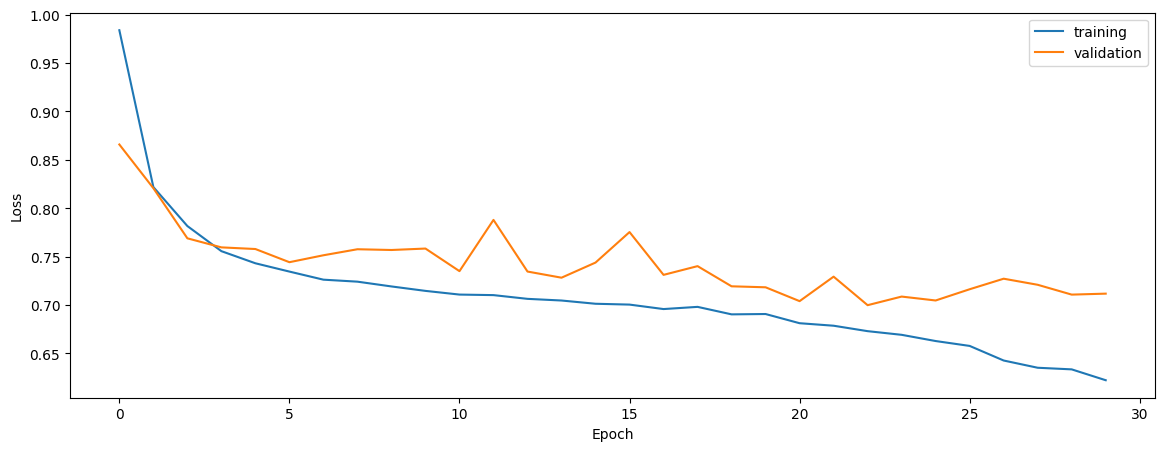

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('train')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.7078790000778064


0.6969883285249588


0.7189526783569541


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.6796822424653867


0.6954005972371438


0.7429632887366325


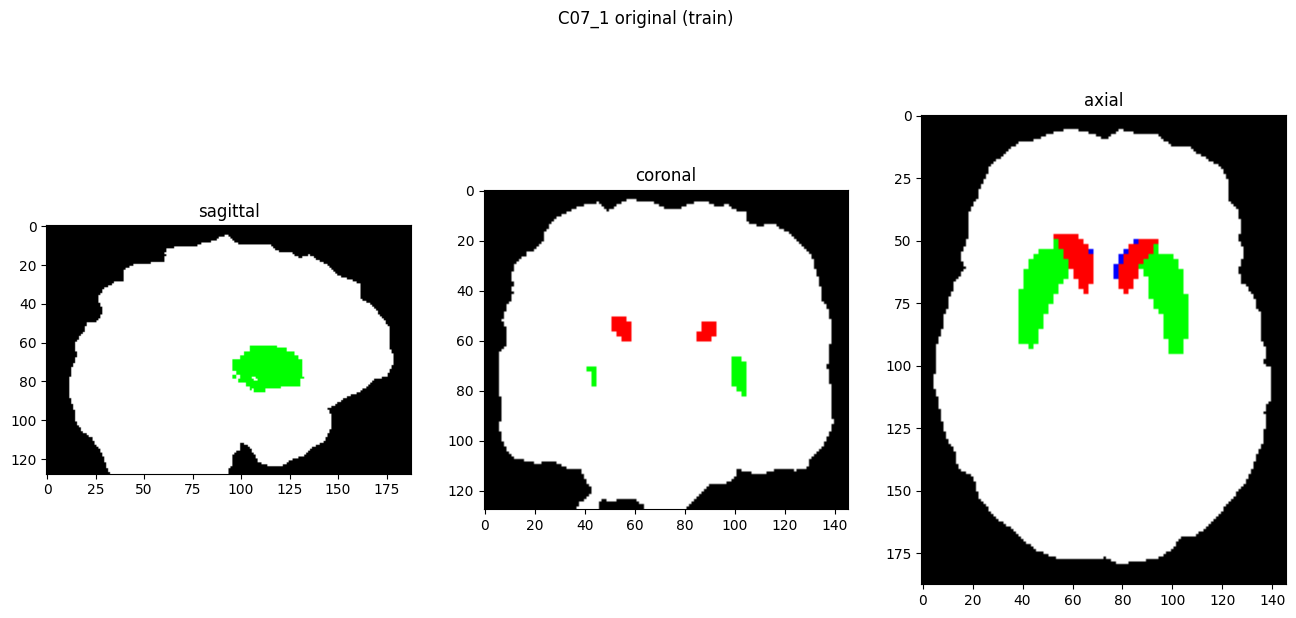

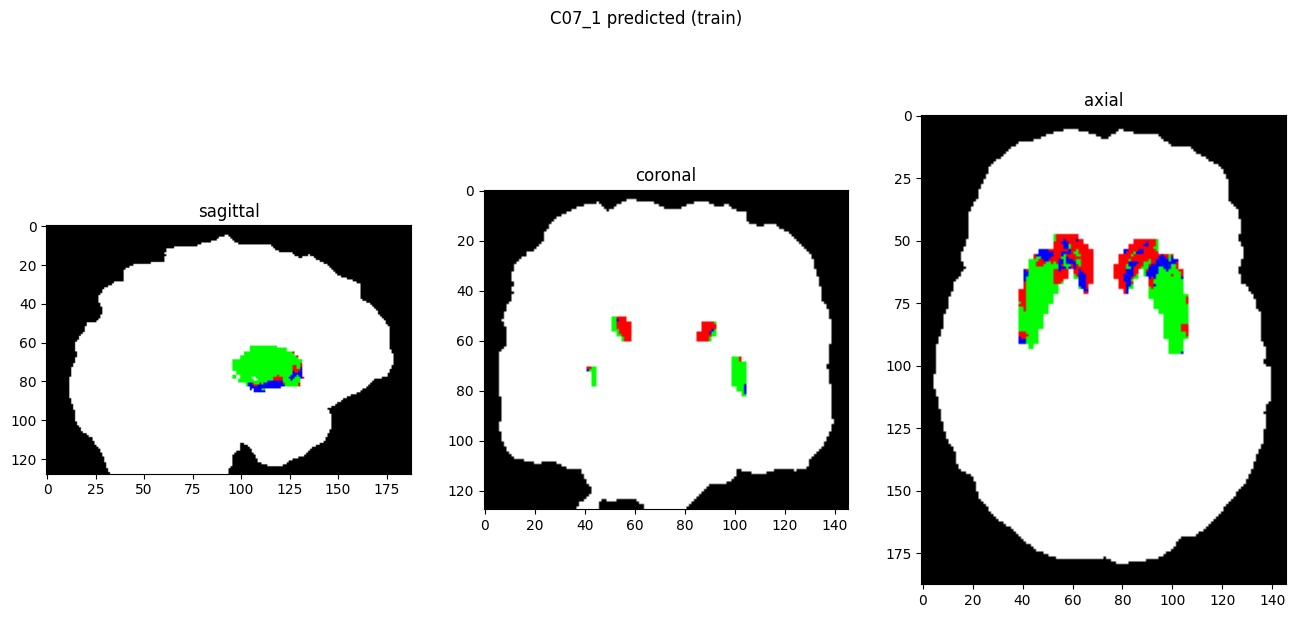

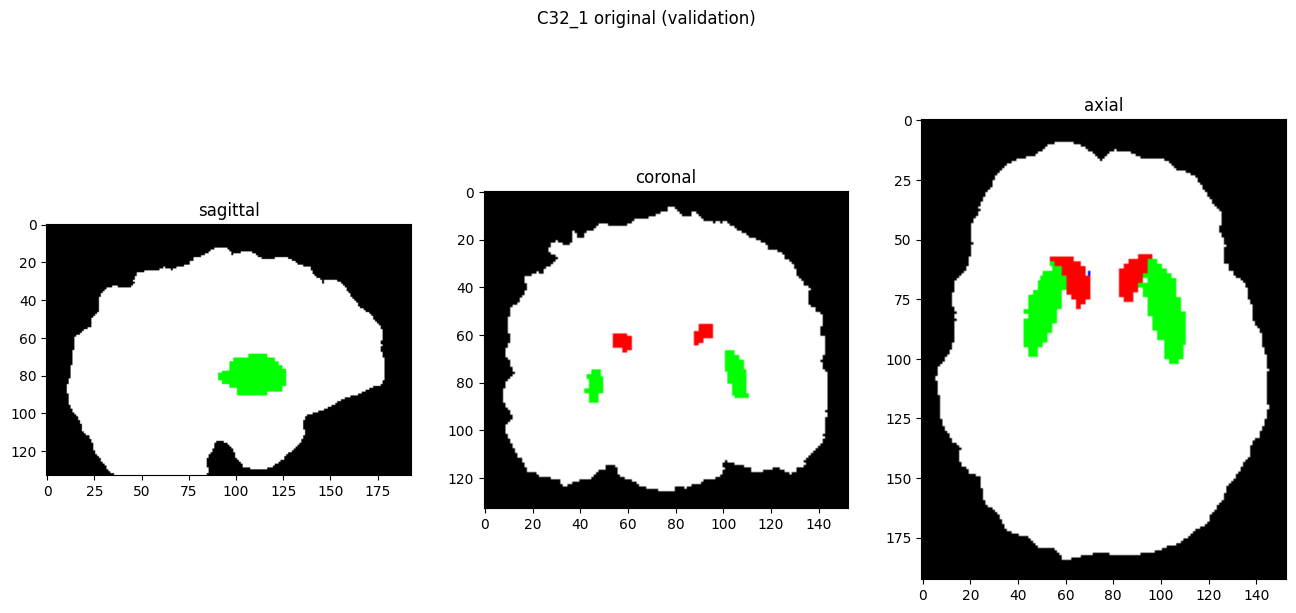

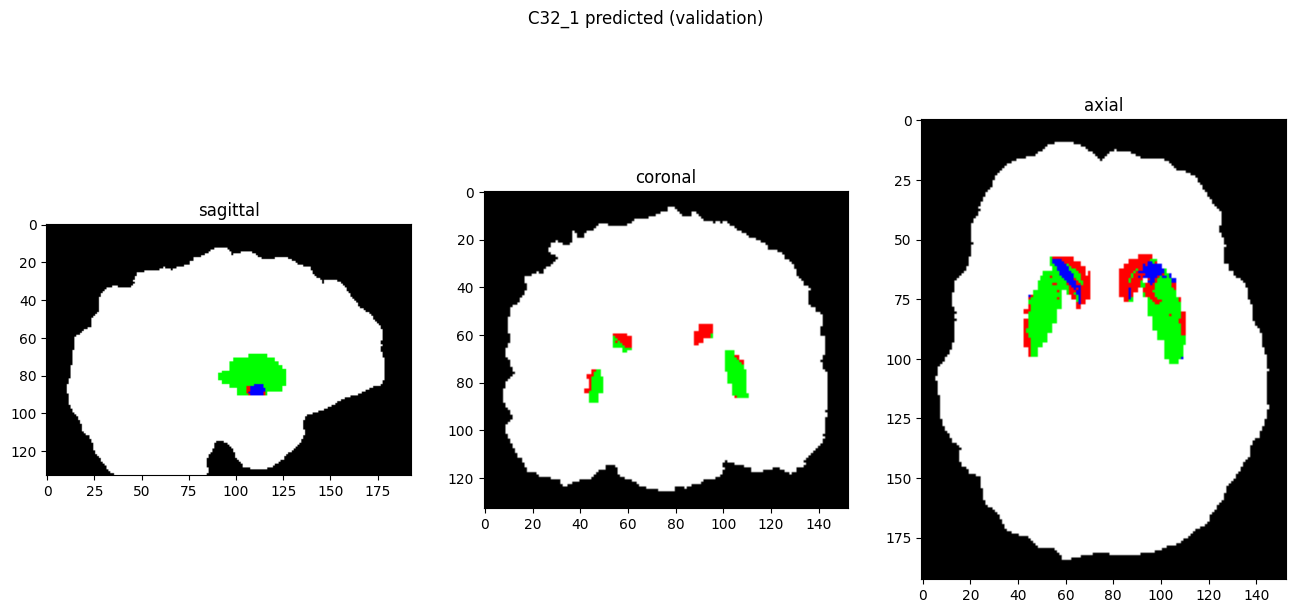

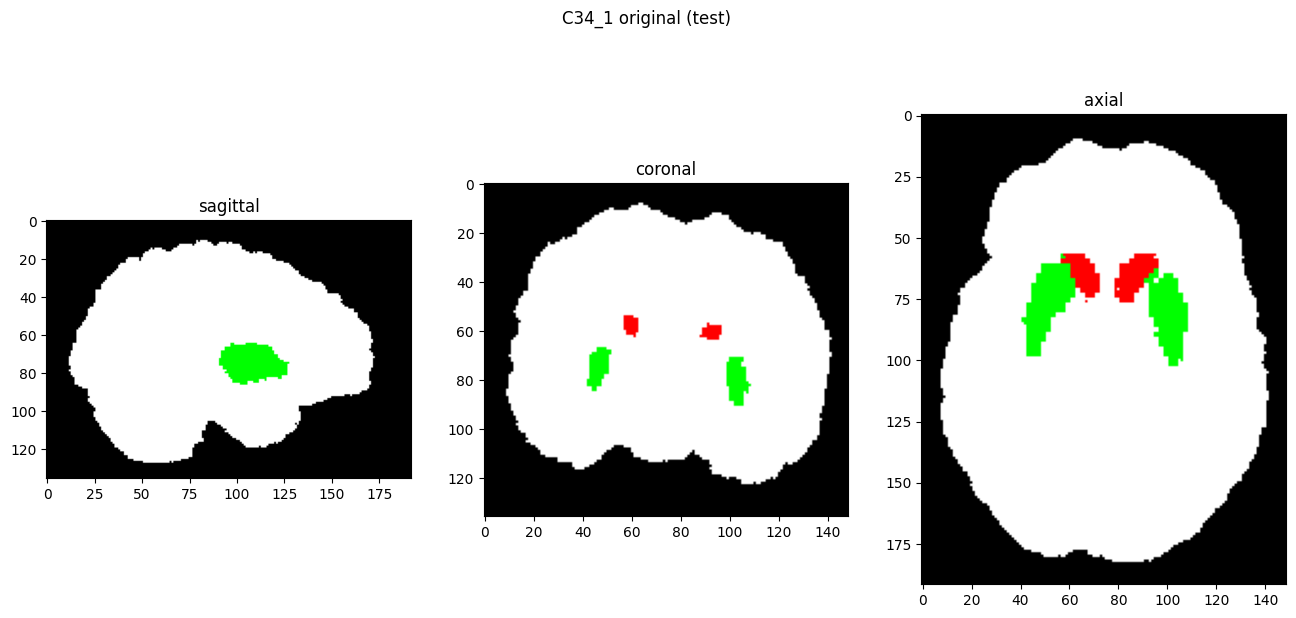

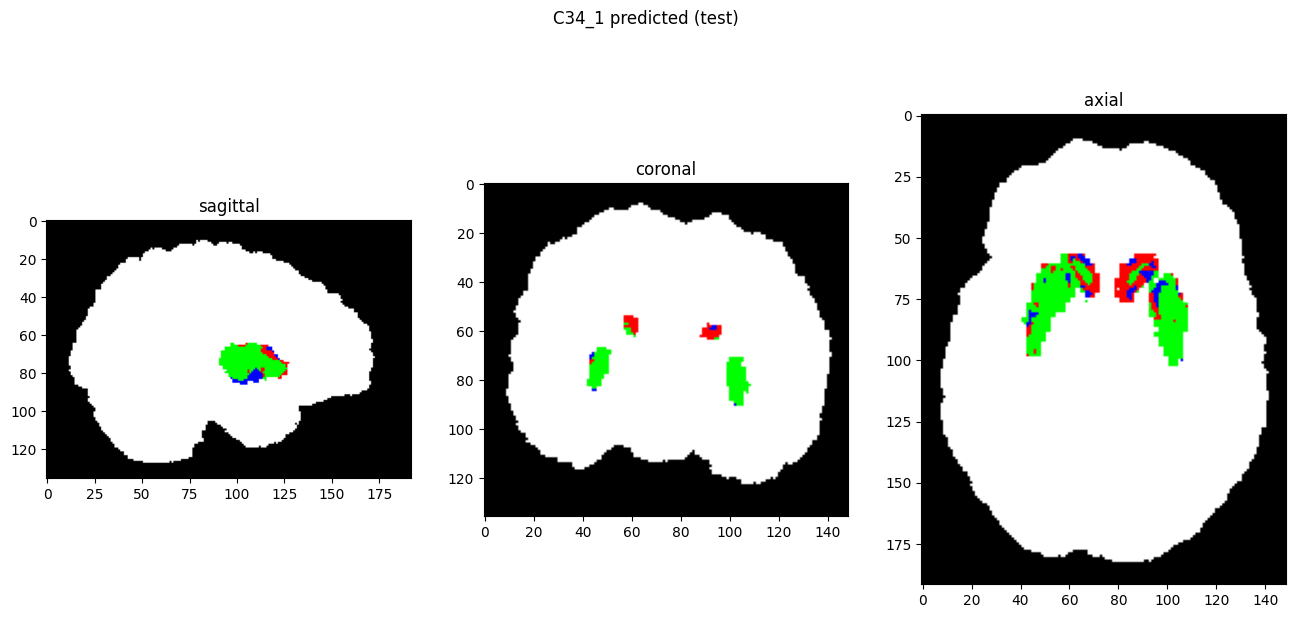

In [9]:
showResults(model, gen, threshold=0)